Osnabrück University - Computer Vision (Winter Term 2022/23) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 02: Image Enhancement

## Introduction

This week's sheet should be solved and handed in before end of **Sunday, November 20, 2022**. If you need help (and Google and other resources were not enough), use the StudIP forum. Please upload your results to your group's Stud.IP folder.

## Assignment 1: Contrast enhancement (5 points)

### a) Image Contrast

Describe the concept of contrast in your own words and introduce different ways to measure it. How can low contrast be caused and when is this a problem (and when not)? What can be done to improve contrast?

Contrast measures the difference in luminance within an image. While global contrast takes the minimal and maximal gray values of an image into consideration, local contrast compares a pixel to its neigbors.

A low global contrast can result from errors or bad conditions during image capture (under- and overexposure). It is clearly visible in a histogram, showing that only a certain interval of the available gray values is used. Small contrast causes problems for the human visual system, making it hard to discover details in the picture. For computer systems a low contrast is usually not a problem. Hence contrast enhancement is usually applied when images are prepared for human inspection.

Low contrast can be improved by making differences of gray values more prominent. This can be done on a global level by stretching the histogram, or on a local level to emphasize details in the image.

### b) Histogram equalization and entropy

How does histogram equalization work? What is entropy and how is it related to histogram equalization? For your answer focus on the (conceptually simpler) continuous case.

A histogram records the distribution of image pixels over the availabe gray values. The goal of histogram equalization is to change the gray values of the image, so that frequent gray values get more space in the histogram while rare gray values are stuffed more densely. The ultimate goal of histogram equalization is to achive an image in which all gray values occur with the same frequency.

Assuming a continuous image (continuous coordinates, continuous gray values), the histogram $H_g$ is the density of the distribution of the gray values in the image $g:C\to V$ (mapping coordinates from $C$ to gray values in $V = [0,m]$ with $m$ being the maximal gray value, i.e. white). Histogram equalization is achieved using a transfer function $T:V\to V$, mapping gray values to gray values. The condition to be fulfilled is, that the density $H_{T\circ g}$ of the resulting image $T\circ g$ is constant (and sums up to 1). Such a transfer function is given by the cummulative density

$$T(v) := \int_0^v H_g(x) \mathrm{d}x$$

Entropy can be considered as a measure of the disorder of a system. The higher the entropy the harder it is to predict the behavior. If all gray values occur with the same probability the system has maximal entropy. Hence histogram equalization maximizes the entropy of the gray values in an image.

### c) Discrete histogram equalization

What problems occur when considering discrete images (i.e. with discrete coordinates and a finite number of gray levels)? Explain the tables on the lecture slides (CV-04 slides 22/23).

In the discrete case, i.e. the case we usually deal with in digital image processiong, an optimal transfer function can usually not be achieved (as it is not possible to continuously deform the histogram). This problem is explained by the tables on (CV-04 slides 22/23): it considers an 3-bit image (i.e. $2^3 = 8$ different gray values) with 1.000 pixels. The histogram values are shown in the second line of the table ("Frequency") while the third line ("H(g)") shows the normalized histogram, i.e. the probability distribution of gray values. The next line displays the accumulated probabilites, which are used to compute transfer function (defined above the table, in this case $N_g=8$). The next line ("Gray value") shows the values computed by the transfer function (i.e. gray value 0 in the original image is mapped to $0.4$, gray value 1 is mapped to $1.6$, etc.). As we consider the discrete case, only integer values are allowed here, so these values are finally ceiled in the last line of the table. On (CV-04 slide 23) the (normalized) histogram of the resulting image is shown below the table. One can see that:
* The gray values are more equally distributed over the range of possible values (this is what histogram equalization tries to achieve)
* However, some gray values (2, 3, and 5) are no longer used in the resulting image (a result of the discreteness)
* The entropy has increased, but does not reach the maximal possible value of $3$ (again due to discreteness)

## Assignment 2: Computing Contrast and Entropy (5 points)


### a) Computing contrast

Provide functions to compute the local contrast, global contrast, and entropy of an image.

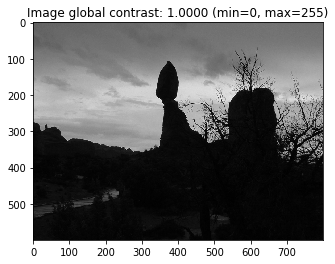

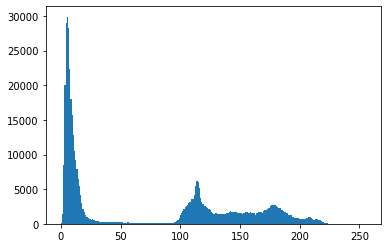

In [2]:
%matplotlib inline
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

def global_contrast(img, value_range=None):
    """
    Compute the global contrast for a given image.
    Args:
        img (ndarray): The grayscale image to compute the contrast for.
        value_range (tuple): The minimum and maximum values of the gray scale.
    
    Returns:
        contrast (float): The global contrast of the image. 
    """

    # determine range: simplified, just checks for uint8 
    if value_range is None:
        value_range = (0, 255) if img.dtype == np.uint8 else (0., 1.)

    # BEGIN SOLUTION
    contrast = (img.max() - img.min()) / (value_range[1] - value_range[0])
    # END SOLUTION
    # contrast = ...

    return contrast

img = imread('images/dark.png')
plt.title("Image global contrast: {:.4f} (min={}, max={})".format(global_contrast(img), img.min(), img.max()))
plt.imshow(img, vmin=0, vmax=255)
plt.show()

plt.hist(img.flatten(), 256, (0, 255))
plt.show()

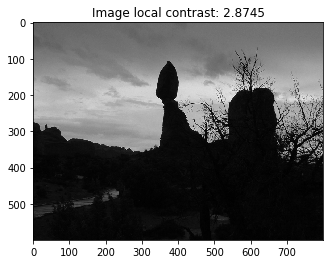

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

def local_contrast(img):
    """
    Compute the local contrast for a given image.
    Args:
        img (ndarray): The grayscale image to compute the contrast for.
    
    Returns:
        contrast (float): The local contrast of the image. 
    """

    # BEGIN SOLUTION
    avg_diff = 0
    for (x,y) in np.ndindex(img.shape):
        neighbors = 0
        neighbors += img[x - 1, y] if x       > 0            else img[x, y]
        neighbors += img[x + 1, y] if (x + 1) < img.shape[0] else img[x, y]
        neighbors += img[x, y - 1] if y       > 0            else img[x, y]
        neighbors += img[x, y + 1] if (y + 1) < img.shape[1] else img[x, y]
        
        avg_diff += abs(img[x,y] - (0.25 * neighbors))
    contrast = avg_diff / img.size

    return contrast

# alternative solution (using convolution):
from scipy.ndimage import convolve
def local_contrast2(img):
    return np.sum(np.abs(convolve(img.astype(float), [[0, -1/4, 0], [-1/4, 1, -1/4], [0, -1/4, 0]]))) / img.size

# END SOLUTION


img = imread('images/dark.png')
plt.title("Image local contrast: {:.4f}".format(local_contrast2(img)))
plt.imshow(img, vmin=0, vmax=255)
plt.show()

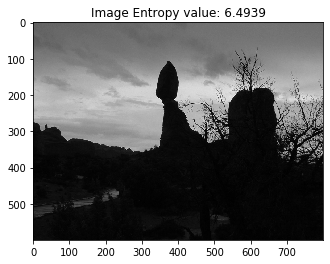

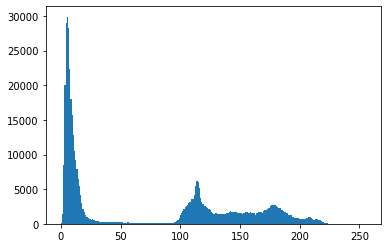

In [5]:
%matplotlib inline
import numpy as np
import math
from imageio import imread
import scipy.stats

def entropy(img):
    """
    Compute the entropy for a given image.
    Args:
        img (ndarray): The grayscale image to compute the entropy for.
    
    Returns:
        img_entropy (float): The entropy of the image. 
    """
    # BEGIN SOLUTION
    hist, _ = np.histogram(img, 256, (0, 255))
    hist_norm = hist / hist.sum()
    log_hist_norm = [math.log2(x) if x > 0 else 0 for x in hist_norm]
    img_entropy = -hist_norm.dot(log_hist_norm)
    return img_entropy
    # END SOLUTION

img = imread('images/dark.png')
plt.title("Image Entropy value: {:.4f}".format(entropy(img)))
plt.imshow(img, vmin=0, vmax=255)
plt.show()

plt.hist(img.flatten(), 256, (0, 255))
plt.show()

assert math.isclose(entropy(img), scipy.stats.entropy(np.unique(img.flat, return_counts=True)[1], base=2))

### b) Example images

* construct an (artificial) image with high global contrast but low local contrast
* construct an (artificial) image with low global constrast but high local contrast
* construct an (artificial) image with maximal entropy but low local contrast

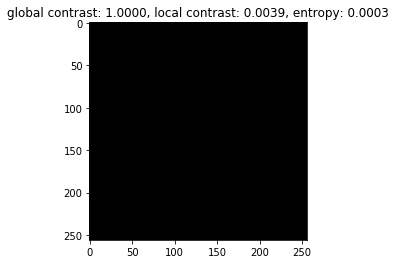

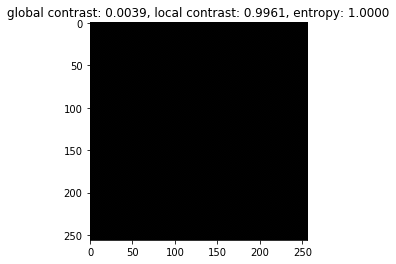

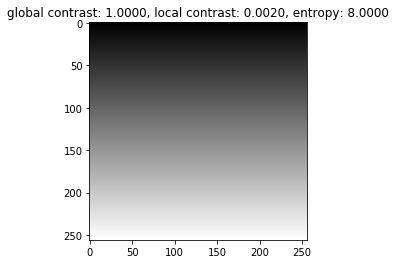

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def image_info(img):
    """ Displays an image, local and global contrast, and the entropy
    
    Args:
        img (ndarray): Image which is displayed and statics are computed for.
        
    """
    info = "global contrast: {:.4f}, local contrast: {:.4f}, entropy: {:.4f}"
    plt.title(info.format(global_contrast(img), local_contrast(img), entropy(img)))
    plt.imshow(img, vmin=0, vmax=255)
    plt.show()


img1 = np.zeros((256, 256),np.uint8)
# BEGIN SOLUTION
img1[0, 0] = 255
# END SOLUTION
image_info(img1)


img2 = np.zeros((256, 256),np.uint8)
# BEGIN SOLUTION
# checkerboard image consisting of ones and zeros 
img2[::2, 1::2] = 1
img2[1::2, ::2] = 1
# END SOLUTION
image_info(img2)


img3 = np.zeros((256, 256),np.uint8)
# BEGIN SOLUTION
for i in range(256):
    img3[i, :] = i
# END SOLUTION
image_info(img3)

## Assignment 3: Adaptive Histogram Equalization (5 points)

We have uploaded the original article on Contrast Limited Adaptive Histogram Equalization to StudIP [Zuiderveld, 1994]. You may use it as a base to answer this exercise.

### a) Adaptive Histogram Equalization (AHE)

Describe in your own words the idea of AHE. Why was it introduced and what are its main drawbacks?

While the standard histogram equalization aims at equalizing the histogram for the full image, adaptive histogram equalization seeks to equalize the histogram locally. In the extreme case, one seeks for an equalized histogram for each image position.

AHE is motivated from the observation, that global histogram equalization may leave local structures with relatively low contrast. 

A drawback of AHE results from its consequent introduction of contrast at all regions of the image. The result is that noise in homogenous regions of the image becomes extremely dominant and distracts attention from the actual structures.

### b) Contrast Limited Adaptive Histogram Equalization (CLAHE)

Describe in your own words the idea of CLAHE. Why was it introduced and how does it work? 

CLAHE aims at overcoming the problems of AHE by reducing the contrast enhancement in homogenous regions. Homogenous regions are detected by high peaks in the local histogram. Such peaks are eliminated by clipping histogram bins over a given threshold and distributing them equally over the histogram. Then this modified histogram is used as a base for computing the transfer function.

### c) Computation of AHE

How can AHE be implemented efficiently? Explain how the interpolation scheme works, why it is a valid approximation, and why it improves the runtime? Can you think of another way to compute AHE efficiently?

Instead of determining the local histogram for the neighborhood of each pixel, one divides the image into grid of rectangular contextual regions and computes a transfer function for each of these regions based on the respective histogram. Then indvidual pixel values are computed by applying a bilinear interpolation of the four neighboring contextual regions, taking the respective region centers as reference points.

Another approach is to use a sliding window, that holds the real histogram of the neighborhood of a pixel. The transfer function for this pixel is computed from that histogram. Then the window is shifted by one pixel, substracting just the "lost" row from the histogram and adding the "new" row. This reduces the time required for computing the histogram.

### d) Applying AHE and CLAHE

Lookup functions for computing HE, AHE and CLAHE in the module `skimage.exposure` and apply them to the image `canada.png`. Compare your results to the lecture slides (CV-04, slide 31).

In [ ]:
%matplotlib inline
# BEGIN SOLUTION
from skimage.exposure import equalize_hist, equalize_adapthist
# END SOLUTION
from imageio.v2 import imread
import matplotlib.pyplot as plt

img = imread('images/canada.png', pilmode='L')

img_he = img # CHANGE THIS
img_ahe = img # CHANGE THIS
img_clahe = img # CHANGE THIS
# BEGIN SOLUTION
img_he = equalize_hist(img)
# equalize_adapthist clip_limit is broken. Works only for interval ]0,1[. Negative clip_limit for AHE
img_ahe = equalize_adapthist(img, clip_limit=-1)
img_clahe = equalize_adapthist(img, clip_limit=.03)
# END SOLUTION

plt.figure(figsize=(12, 15))
plt.subplot(4,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(4,2,2)
plt.title("entropy={:.4f}".format(entropy(img)))
plt.hist(img.flatten(), 256, (0, 255))

plt.subplot(4,2,3)
plt.title("HE")
plt.imshow(img_he)
plt.subplot(4,2,4)
plt.title("entropy={:.4f}".format(entropy(img_he)))
plt.hist(img_he.flatten(), 256, (0, 1))

plt.subplot(4,2,5)
plt.title("AHE")
plt.imshow(img_ahe)
plt.subplot(4,2,6)
plt.title("entropy={:.4f}".format(entropy(img_ahe)))
plt.hist(img_ahe.flatten(), 256, (0, 1))

plt.subplot(4,2,7)
plt.title("CLAHE")
plt.imshow(img_clahe)
plt.subplot(4,2,8)
plt.title("entropy={:.4f}".format(entropy(img_clahe)))
plt.hist(img_clahe.flatten(), 256, (0, 1))

plt.show()

## Assignment 4: Colormaps (5 points)

Colormaps can be used to map a grayscale image to a pseudo color image for contrast enhancment for human viewing. Three non-monotonic functions are applied to map a gray value to each of the three color channels of the output image.


### a) Describe the following three colormap classes in one sentence each:

* Sequential
* Diverging
* Qualitative

You may have a look at the matplotlib documentation.

* Sequential: Change in lightness and often saturation of color incrementally, often using a single hue; should be used for representing information that has ordering.
* Diverging: Change in lightness and possibly saturation of two different colors that meet in the middle at an unsaturated color; should be used when the information being plotted has a critical middle value, such as topography or when the data deviates around zero.
* Qualitative: Often are miscellaneous colors; should be used to represent information which does not have ordering or relationships.

Taken from: https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html

For each of the above colormap classes give one example and display the red, green, and blue curves like on (CV-04, slide 35):

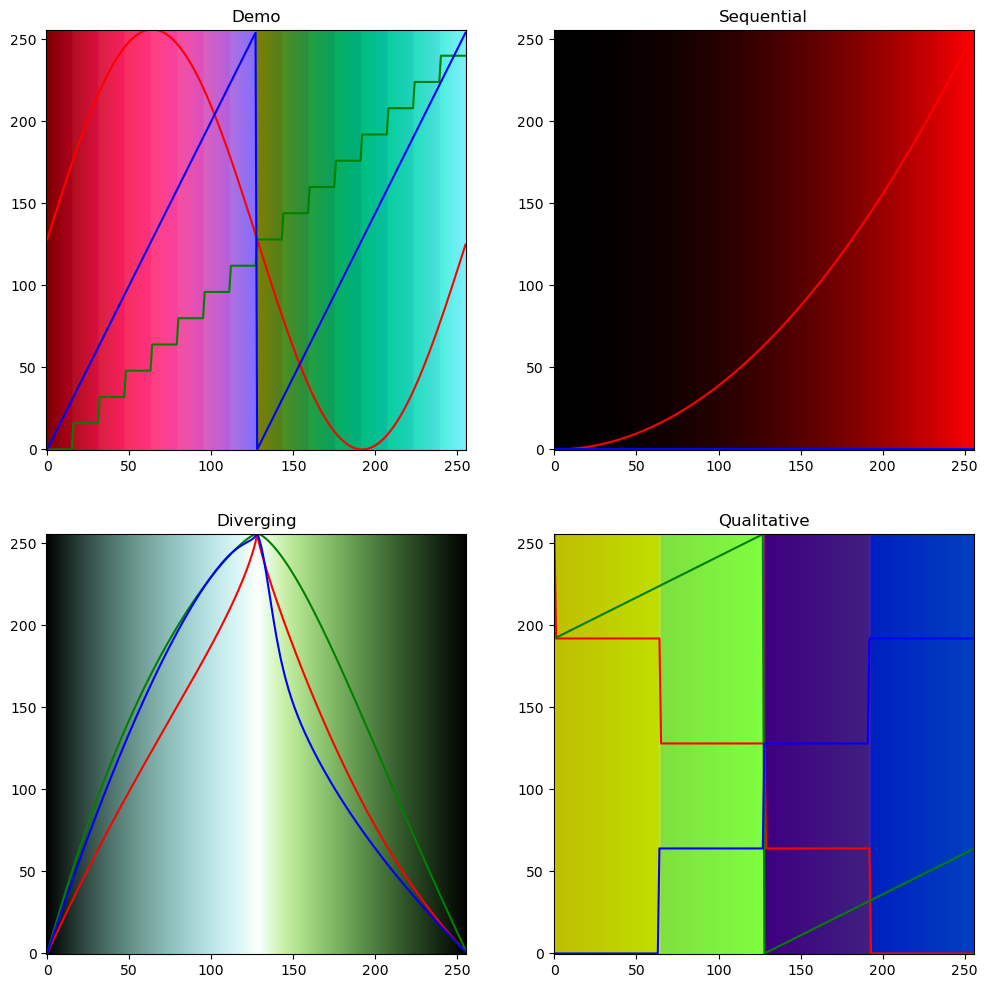

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

colors = []

def f(x):
    return np.sin(x/256*2*np.pi)*128+128


# The following is just for demonstration: replace and extend by your own examples
colors.append((np.asarray((lambda x: np.sin(x/256*2*np.pi)*128+128, 
                           lambda x: (x//16) * 16,
                           lambda x: (2*x) % 256)),
              "Demo"))
# BEGIN SOLUTION
# Credit to Philipp Thölke, Tula Böschen and Emilia Arens for this great solution!

# sequential color map
colors.append((np.asarray((lambda x: ((x / 256) ** 2) * 255, 
                           lambda x: 0*x, # x,
                           lambda x: 0*x )), #((x / 256) ** 0.5) * 255)),
              "Sequential"))

# diverging color map
colors.append((np.asarray((lambda x: 256 - (((abs(128 - x) / 128) ** (0.3 + 1 / (1 + np.exp(-(128 - x) / 100)))) * 256), 
               lambda x: 256 - (((abs(128 - x) / 128) ** (0.9 + 1 / (1 + np.exp(-(128 - x) / 75)))) * 256),
               lambda x: 256 - (((abs(128 - x) / 128) ** (0.5 + 1 / (1 + np.exp(-(128 - x) / 5)))) * 256))),
               "Diverging"))


# Credit to Franca Boße, Rena Birner and Rodrigo Oyarzo Baez for this great solution!

# qualitative colormap
colors.append((np.asarray((lambda x: ((256-x)//64) * 64, 
                           lambda x: (0.5*x+192) % 256, 
                           lambda x: (x//64) * 64)),
              "Qualitative"))

# END SOLUTION

gray = np.arange(0,256)
a = np.tile(np.arange(256),(256,1))

plt.figure(figsize=(12,12))
for i, (color, label) in enumerate(colors):
    plt.subplot((len(color)//2)+1,2,i+1)
    plt.plot(gray, color[0](gray), 'red')
    plt.plot(gray, color[1](gray), 'green')
    plt.plot(gray, color[2](gray), 'blue')
    plt.imshow(np.stack([color[0](a),color[1](a),color[2](a)],axis=2)/256, origin='lower')
    plt.title(label)
plt.show()

### b) Implement Cube Helix colormapping 
Generate a LookUp table with $256 \times 3$ entries describing the color values for all gray values beginning with black (0) up to white (255). Use the given parameters and use the following formula to compute an RGB value from a gray value $g$:
$$ \begin{pmatrix}R \\ G \\ B\end{pmatrix} =  g ^ \gamma + a \begin{pmatrix}-0.14861 & + 1.78277 \\
-0.29227 & -0.90649 \\ +1.97294 & 0\end{pmatrix} \begin{pmatrix}\cos \theta \\ \sin \theta\end{pmatrix}$$
with $\theta = 2 \pi (\frac{\text{start_color }}{3} + \text{rotations}\cdot g)$ and $ a = \frac{\gamma\cdot\text{hue}\cdot g\cdot( 1 - \gamma g)}{2}$ (with 'start_color', 'rotations' and 'hue' being parameters describing the form of the helix, and $\gamma$ being the usual $\gamma$-factor).

Remember that this formula is for values between $0$ and $1$.
For more information you may refer to http://astron-soc.in/bulletin/11June/289392011.pdf

In [ ]:
%matplotlib inline
import numpy as np
from imageio.v2 import imread
import matplotlib.pyplot as plt

start_color = 1
rotations = 3
hue = 2
gamma = 1
m = np.mat([[-.14861, 1.78277],
            [-.29227, -.90649],
            [1.97294, 0]])

def generate_cube_helix_lookup_table():
    """Generate a lookup table for cube helix color mapping.
    
    Return: 
        lookup_table (ndarray): The cube helix color map. (256,3)
    """
    lookup_table = np.empty((256,3), float)
    
    for i in np.arange(256):
        # BEGIN SOLUTION
        j = i/256
        lambda_y = j ** gamma
        theta = 2 * np.pi * (start_color/3 + rotations * j)
        a = hue * lambda_y * (1 - lambda_y) / 2
        lookup_table[i, :] = np.mat([j,j,j]) + (a * m * \
                    np.mat([np.cos(theta), np.sin(theta)]).T).T
    
        # END SOLUTION
    return lookup_table


def apply_colormap(img, loookup_table):
    """Apply a colormap to an image
    
    Args:
        img (ndarray): The image (ndim=2).
        lookup_table (ndarray): The lookup table (shape=(256,3)).
        
    Return:
        color_img (ndarray): The color image resulting from application of the colormap.
    """
    color_img = loookup_table[img]
    color_img[color_img>1] = 1.
    color_img[color_img<0] = 0.
    return color_img

img = imread('images/lung.png', pilmode='L')
lookup_table = generate_cube_helix_lookup_table()
img2 = apply_colormap(img, lookup_table)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(img, cmap = 'gray'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img2); plt.axis('off')
plt.show()

### Jet Colormap [Bonus]

Explain why the Jet Colormap (used, for example, as standard colormap in matlab), is problematic compared to Cube Helix. Think of perceived luminance and black and white printing.

In [ ]:
# This code was taken from 
# https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/

def grayify_cmap(cmap):
    """Return a grayscale version of the colormap
    
    Args:
        cmap (ndarray): RGB Colormap.
    
    Returns:
        (ndarray): Gray Colormap.
    
    """
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

def show_colormap(cmap):
    """Plots RGB colormap and grayified colormap
    
    Args: 
        cmap (ndarray): Colormap.
    
    """
    im = np.outer(np.ones(10), np.arange(100))
    fig, ax = plt.subplots(2, figsize=(6, 1.5),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.1)
    ax[0].imshow(im, cmap=cmap)
    ax[1].imshow(im, cmap=grayify_cmap(cmap))
    
# printing the jet colormap and how it would look like if printed black and white
show_colormap('jet')

# doing the same for cube helix
show_colormap('cubehelix')

As can be seen in the image above, the jet colormap is not linear with respect to the luminance. If a plot that was created using the jet colormap is printed on a black and white printer, weird artifacts occur. One might expect that low values correspond to darker colors and high values correspond to brighter colors, but that is not the case. But the map is also not diverging in the sense that it is bright in the middle and darker towards the edges of the spectrum. Instead, there are two luminance peaks left and right of the middle, which might be really confusing and could create fake "highlights" in the data. 